### Test wtih JuMP

In [1]:
include("../Problems/JuMP/robot_JMP.jl")
RobotJMP = robot_JMP();

set_optimizer(RobotJMP,Ipopt.Optimizer)
set_attribute(RobotJMP, "print_level", 5)
set_optimizer_attribute(RobotJMP,"tol",1e-8)
set_optimizer_attribute(RobotJMP,"constr_viol_tol",1e-6)
set_optimizer_attribute(RobotJMP,"max_iter",1000)

In [2]:
println("Solving...")
optimize!(RobotJMP)
println()

# Display results
if termination_status(RobotJMP) == MOI.OPTIMAL
    println("  Solution is optimal")
elseif  termination_status(RobotJMP) == MOI.LOCALLY_SOLVED
    println("  (Local) solution found")
elseif termination_status(RobotJMP) == MOI.TIME_LIMIT && has_values(RobotJMP)
    println("  Solution is suboptimal due to a time limit, but a primal solution is available")
else
    error("  The model was not solved correctly.")
end
println("  objective value = ", objective_value(RobotJMP))
println()


# Retrieves values (including duals - sign convention according to Pontrjagin max principle)
N = 400
L = 4.0
a = 1.0
b = 3.0
tf = 1.0
h = tf / N
rho_ = RobotJMP[:rho];
the_ = RobotJMP[:the];
phi_ = RobotJMP[:phi];
rho_dot_ = RobotJMP[:rho_dot];
the_dot_ = RobotJMP[:the_dot];
phi_dot_ = RobotJMP[:phi_dot];
I_the_ = RobotJMP[:I_the];
I_phi_ = RobotJMP[:I_phi];

u_ = RobotJMP[:u];

con_x1 = RobotJMP[:con_x1];
con_x2 = RobotJMP[:con_x2];
con_x3 = RobotJMP[:con_x3];

Δtt = value.(h)
t = Vector((0:N)*Δtt);

p = - [ [ dual(con_x1[i]), dual(con_x2[i]), dual(con_x3[i]) ] for i in 1:N ];



x1 = Vector(value.(x1_)) ;
x2 = Vector(value.(x2_)) ;
x3 = Vector(value.(x3_));
u = Vector(value.(u_)) ;

x =  [ [ x1[i], x2[i], x3[i] ] for i in 1:N ];


Solving...

******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

This is Ipopt version 3.14.14, running with linear solver MUMPS 5.6.2.

Number of nonzeros in equality constraint Jacobian...:     8012
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:    10200

Total number of variables............................:     1810
                     variables with only lower bounds:        1
                variables with lower and upper bounds:     1206
                     variables with only upper bounds:        0
Total number of equality constraints.................:     1212
Total number of i

KeyError: KeyError: key :x1 not found

In [3]:
using Plots

x1_plot = plot(t, [ x[i][1] for i in 1:N-1 ], xlabel = "t", ylabel = "x1", legend = false)
x2_plot = plot(t, [ x[i][2] for i in 1:N-1 ], xlabel = "t", ylabel = "x2", legend = false)
x3_plot = plot(t, [ x[i][3] for i in 1:N-1 ], xlabel = "t", ylabel = "x3", legend = false)
px1_plot = plot(t, [ p[i][1] for i in 1:N-1 ], xlabel = "t", ylabel = "px1", legend = false)
px2_plot = plot(t, [ p[i][2] for i in 1:N-1 ], xlabel = "t", ylabel = "px2", legend = false)
px3_plot = plot(t, [ p[i][3] for i in 1:N-1 ], xlabel = "t", ylabel = "px3", legend = false)
u_plot = plot(t, [ u[i] for i in 1:N-1 ], xlabel = "t", ylabel = "u", legend = false)

layout = @layout [a b; c d; e f; g]
x_plot = plot(x1_plot, px1_plot, x2_plot, px2_plot, x3_plot, px3_plot, u_plot, layout = layout)
display(x_plot)

UndefVarError: UndefVarError: `x` not defined

### Test with OptimalControl

In [2]:
include("../Problems/OptimalControl/robot_OC.jl")
RobotOC = robot_OC()


The (autonomous) optimal control problem is of the form:

    minimize  J(x, u, tf) = g(x(0), x(tf), tf)

    subject to

        ẋ(t) = f(x(t), u(t), tf), t in [0, tf] a.e.,

        ηl ≤ η(x(t), tf) ≤ ηu, 
        ϕl ≤ ϕ(x(0), x(tf), tf) ≤ ϕu, 

    where x(t) ∈ R⁶, u(t) ∈ R³ and tf ∈ R.

Declarations (* required):



┌────────┬────────┬──────────┬──────────┬───────────┬────────────┬─────────────┐
│ times* │ state* │ control* │ variable │ dynamics* │ objective* │ constraints │
├────────┼────────┼──────────┼──────────┼───────────┼────────────┼─────────────┤
│     ✅ │     ✅ │       ✅ │       ✅ │        ✅ │         ✅ │          ✅ │
└────────┴────────┴──────────┴──────────┴───────────┴────────────┴─────────────┘


In [3]:
sol = OptimalControl.solve(RobotOC)

Method = (:direct, :adnlp, :ipopt)
This is Ipopt version 3.14.14, running with linear solver MUMPS 5.6.2.

Number of nonzeros in equality constraint Jacobian...:     4812
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:     2222

Total number of variables............................:      910
                     variables with only lower bounds:        1
                variables with lower and upper bounds:      303
                     variables with only upper bounds:        0
Total number of equality constraints.................:      612
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  1.0000000e-01 4.40e+00 0.00e+00   0.

CTBase.OptimalControlSolution

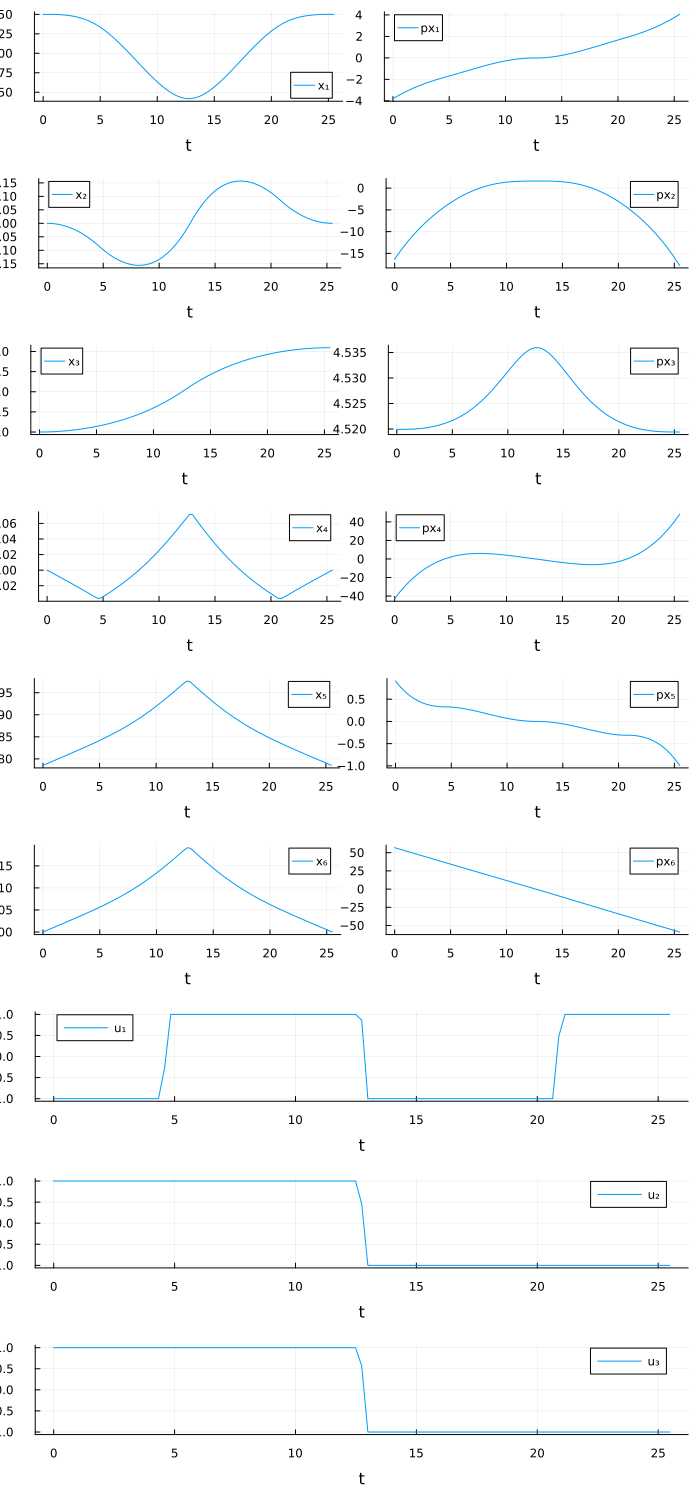

In [11]:
using Plots
p1 = plot(plot(sol)[1])

p2 = plot(plot(sol)[2])

p3 = plot(plot(sol)[3])

p4 = plot(plot(sol)[4])

p5 = plot(plot(sol)[5])

p6 = plot(plot(sol)[6])

p7 = plot(plot(sol)[7])

p8 = plot(plot(sol)[8])

p9 = plot(plot(sol)[9])

p10 = plot(plot(sol)[10])

p11 = plot(plot(sol)[11])

p12 = plot(plot(sol)[12])

p13 = plot(plot(sol)[13])

p14 = plot(plot(sol)[14])

p15 = plot(plot(sol)[15])

layout = @layout [a b; c d; e f; g h; i j; k l; m; o; p]

x_plot = plot(p1, p7, p2, p8, p3, p9, p4, p10, p5, p11, p6, p12, p13, p14, p15, layout = layout)
x_plot = plot!(size = (700, 1500))

display(x_plot)

### Plot results

In [ ]:
p1 = plot(plot(sol)[1])
p1 = plot!(t, [ x[i][1] for i in 1:N-1 ], xlabel = "t", ylabel = "x1", legend = false)

p3 = plot(plot(sol)[2])
p3 = plot!(t, [ x[i][2] for i in 1:N-1 ], xlabel = "t", ylabel = "x2", legend = false)

p5 = plot(plot(sol)[3])
p5 = plot!(t, [ x[i][3] for i in 1:N-1 ], xlabel = "t", ylabel = "x3", legend = false)

p2 = plot(plot(sol)[4])
p2 = plot!(t, [ p[i][1] for i in 1:N-1 ], xlabel = "t", ylabel = "px1", legend = false)

p4 = plot(plot(sol)[5])
p4 = plot!(t, [ p[i][2] for i in 1:N-1 ], xlabel = "t", ylabel = "px2", legend = false)

p6 = plot(plot(sol)[6])
p6 = plot!(t, [ p[i][3] for i in 1:N-1 ], xlabel = "t", ylabel = "px3", legend = false)

p7 = plot(plot(sol)[7] , label ="OC")
p7 = plot!(t, [ u[i] for i in 1:N-1 ], xlabel = "t", ylabel = "u", legend = false, label = "JuMP")
p7 = plot!(legend=:outerbottom, legendcolumns=2)

layout = @layout [a b; c d; e f; g]

x_plot = plot(p1, p2, p3, p4, p5, p6, p7, layout = layout)
x_plot = plot!(size = (700, 700))

display(x_plot)